In [27]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


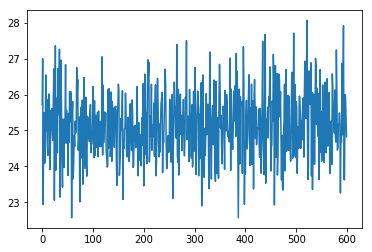

In [3]:
plt.plot(nino34[::12]);

In [4]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [5]:
oni = ONI(nino34)

In [6]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [7]:
clm = climatology(nino34)

In [8]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [9]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [10]:
T = 12      # prediction timeline
H = 48   # history used for prediction
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [13]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

labels = np.ndarray((size, 12), dtype = np.float64)

for t in range(12):
    for i in range(size):
        labels[i,t] = anm[i + H + t]

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

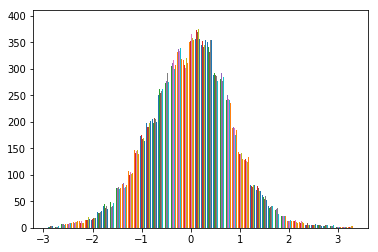

In [18]:
plt.hist(train_labels, bins=50);

# Simple Model

In [19]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 60

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(12,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/60
5712/5712 [==============================] - 3s 558us/step - loss: 0.5386 - mean_squared_error: 0.4957 - mean_absolute_error: 0.5386
Epoch 2/60
5712/5712 [==============================] - 3s 476us/step - loss: 0.4987 - mean_squared_error: 0.4373 - mean_absolute_error: 0.4987
Epoch 3/60
5712/5712 [==============================] - 3s 478us/step - loss: 0.4830 - mean_squared_error: 0.4166 - mean_absolute_error: 0.4830
Epoch 4/60
5712/5712 [==============================] - 2s 427us/step - loss: 0.4737 - mean_squared_error: 0.4025 - mean_absolute_error: 0.4737
Epoch 5/60
5712/5712 [==============================] - 2s 403us/step - loss: 0.4636 - mean_squared_error: 0.3894 - mean_absolute_error: 0.4636
Epoch 6/60
5712/5712 [==============================] - 2s 401us/step - loss: 0.4529 - mean_squared_error: 0.3736 - mean_absolute_error: 0.4529
Epoch 7/60
5712/5712 [==============================] - 2s 408us/step - loss: 0.4401 - mean_squared_error: 0.3567 - mean_absolute_error:

5712/5712 [==============================] - 3s 521us/step - loss: 0.1223 - mean_squared_error: 0.0261 - mean_absolute_error: 0.1223
Epoch 57/60
5712/5712 [==============================] - 3s 511us/step - loss: 0.1197 - mean_squared_error: 0.0251 - mean_absolute_error: 0.11971s - loss: 0.120
Epoch 58/60
5712/5712 [==============================] - 3s 549us/step - loss: 0.1205 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1205
Epoch 59/60
5712/5712 [==============================] - 3s 483us/step - loss: 0.1189 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1189
Epoch 60/60
5712/5712 [==============================] - 2s 394us/step - loss: 0.1180 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1180
0.20092201433261903 0.3218076320923343


In [48]:
pred = model.predict(train)

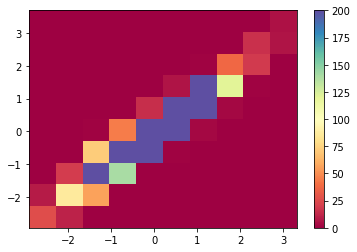

In [61]:
T0 = 11
plt.hist2d(train_labels[:,T0], pred[:,T0], cmap = plt.cm.Spectral, vmax = 200);
plt.colorbar();

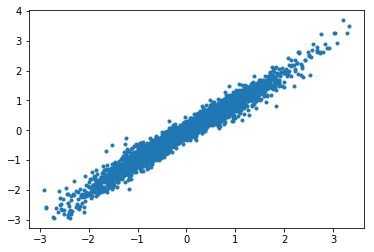

In [62]:
plt.plot(train_labels[:,T0], pred[:,T0], ".");

In [63]:
pred_val = model.predict(val)

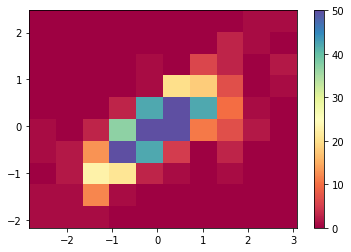

In [64]:
plt.hist2d(val_labels[:,T0], pred_val[:,T0], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

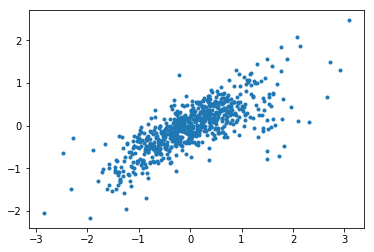

In [65]:
plt.plot(val_labels[:,T0], pred_val[:,T0], ".");

In [66]:
def correlation(x, y):
    x0 = x - np.mean(x)
    y0 = y - np.mean(y)
    return np.mean(x0 * y0) / np.sqrt((np.mean(x0**2) * (np.mean(y0**2))))

In [67]:
print(correlation(train_labels[:,T0], pred[:,T0]))
print(correlation(val_labels[:,T0], pred_val[:,T0]))

0.9800881157810357
0.7727922980435417
